In [1]:
import torch
import torch.utils.data as Data
import torch.nn as nn
from torch.autograd import Variable
import pandas as pd
import os
import matplotlib.pyplot as plt
from IPython import display

# Read 3M TUG csv data files, y = integer representation of file name so we can trace these files, i.e., '20140805.20 => y=2014080520'

In [2]:
DIR = "C:/Users/ADMIN/Desktop/Feng-Yuan 3MTUG"

In [3]:
fileNo = 0
for fname in os.listdir(DIR):
    fileNo = fileNo +1
    fname_with_path = DIR + '/' + fname
    df = pd.read_csv(fname_with_path)
    df = df[0:500]  # select the first 500 data 
    tensor = torch.FloatTensor(df[['X', 'Y', 'Z']].values.tolist())
    tensor = tensor.view(1, 500, 3)
    if(fileNo == 1):
        resultx = tensor
    else:
        resultx = torch.cat((resultx, tensor), 0)

    y = float(fname[:-4])
    y = torch.FloatTensor([y])
    if(fileNo == 1):
        resulty = y
    else:
        resulty = torch.cat((resulty, y), 0)

In [4]:
print(resultx.shape, resulty.shape) # we have 150 files, each file we take first 500 data points

torch.Size([150, 500, 3]) torch.Size([150])


# Define mini-batch loader

In [5]:
torch_dataset = Data.TensorDataset(data_tensor=resultx, target_tensor=resulty)

In [6]:
loader = Data.DataLoader(
    dataset=torch_dataset,     
    batch_size=150,       # 1 batch contains all files
    shuffle=True,              
    num_workers=2,             
)

# Define NN 

In [7]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(500*3, 2000),
            nn.BatchNorm1d(2000),
            nn.Tanh(),
            nn.Linear(2000, 800),
            nn.BatchNorm1d(800),
            nn.Tanh(),
            nn.Linear(800, 200),
            nn.BatchNorm1d(200),
            nn.Tanh(),
            nn.Linear(200, 2),   # compress to 2 features which can be visualized in plt
        )
        self.decoder = nn.Sequential(
            nn.Linear(2, 200),
            nn.BatchNorm1d(200),
            nn.Tanh(),
            nn.Linear(200, 800),
            nn.BatchNorm1d(800),
            nn.Tanh(),
            nn.Linear(800, 2000),
            nn.BatchNorm1d(2000),
            nn.Tanh(),
            nn.Linear(2000, 500*3),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [8]:
autoencoder = AutoEncoder()

In [9]:
autoencoder

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=1500, out_features=2000)
    (1): BatchNorm1d(2000, eps=1e-05, momentum=0.1, affine=True)
    (2): Tanh()
    (3): Linear(in_features=2000, out_features=800)
    (4): BatchNorm1d(800, eps=1e-05, momentum=0.1, affine=True)
    (5): Tanh()
    (6): Linear(in_features=800, out_features=200)
    (7): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True)
    (8): Tanh()
    (9): Linear(in_features=200, out_features=2)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=200)
    (1): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True)
    (2): Tanh()
    (3): Linear(in_features=200, out_features=800)
    (4): BatchNorm1d(800, eps=1e-05, momentum=0.1, affine=True)
    (5): Tanh()
    (6): Linear(in_features=800, out_features=2000)
    (7): BatchNorm1d(2000, eps=1e-05, momentum=0.1, affine=True)
    (8): Tanh()
    (9): Linear(in_features=2000, out_features=1500)
  )
)

In [10]:
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.005)

In [11]:
loss_func = nn.MSELoss()

# Run loops of epochs

In [12]:
epoch = 0

In [13]:
losslst = []
for epoch in range(50):
    for step, (x, y) in enumerate(loader):
        b_x = Variable(x.view(-1, 500*3)) 
        b_y = Variable(x.view(-1, 500*3)) 
        
        encoded, decoded = autoencoder(b_x)
            
        # calculate loss and conduct back propagation
        loss = loss_func(decoded, b_y)      # mean square error
        print('Epoch: ', epoch, '| step: ', step, '| train loss: ', loss.data.numpy()[0])
        losslst.append(loss.data.numpy()[0])
        optimizer.zero_grad()               # clear gradients for this training step
        loss.backward()                     # backpropagation, compute gradients
        optimizer.step()                    # apply gradients
    epoch = epoch + 1

Epoch:  0 | step:  0 | train loss:  42.60043
Epoch:  1 | step:  0 | train loss:  43.463097
Epoch:  2 | step:  0 | train loss:  49.60075
Epoch:  3 | step:  0 | train loss:  40.938503
Epoch:  4 | step:  0 | train loss:  40.232166
Epoch:  5 | step:  0 | train loss:  39.122955
Epoch:  6 | step:  0 | train loss:  38.057583
Epoch:  7 | step:  0 | train loss:  36.74654
Epoch:  8 | step:  0 | train loss:  34.837154
Epoch:  9 | step:  0 | train loss:  32.53292
Epoch:  10 | step:  0 | train loss:  29.946218
Epoch:  11 | step:  0 | train loss:  27.13109
Epoch:  12 | step:  0 | train loss:  24.180826
Epoch:  13 | step:  0 | train loss:  21.091063
Epoch:  14 | step:  0 | train loss:  17.959345
Epoch:  15 | step:  0 | train loss:  14.802066
Epoch:  16 | step:  0 | train loss:  11.842058
Epoch:  17 | step:  0 | train loss:  9.294571
Epoch:  18 | step:  0 | train loss:  7.3632617
Epoch:  19 | step:  0 | train loss:  6.112267
Epoch:  20 | step:  0 | train loss:  5.539361
Epoch:  21 | step:  0 | train l

# Visualize the results

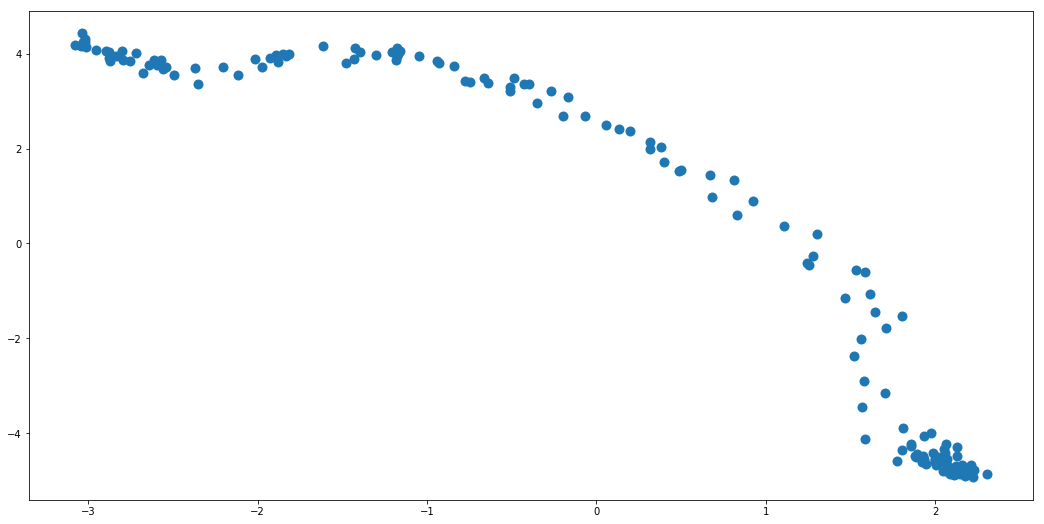

In [14]:
label = y.numpy().reshape(150)
plt.figure(figsize=(18,9)) # set the figure size to 18 x 9 inches
plt.scatter(encoded.data.numpy()[:, 0], encoded.data.numpy()[:, 1], s=100, lw=0, cmap='RdYlGn')
plt.show()

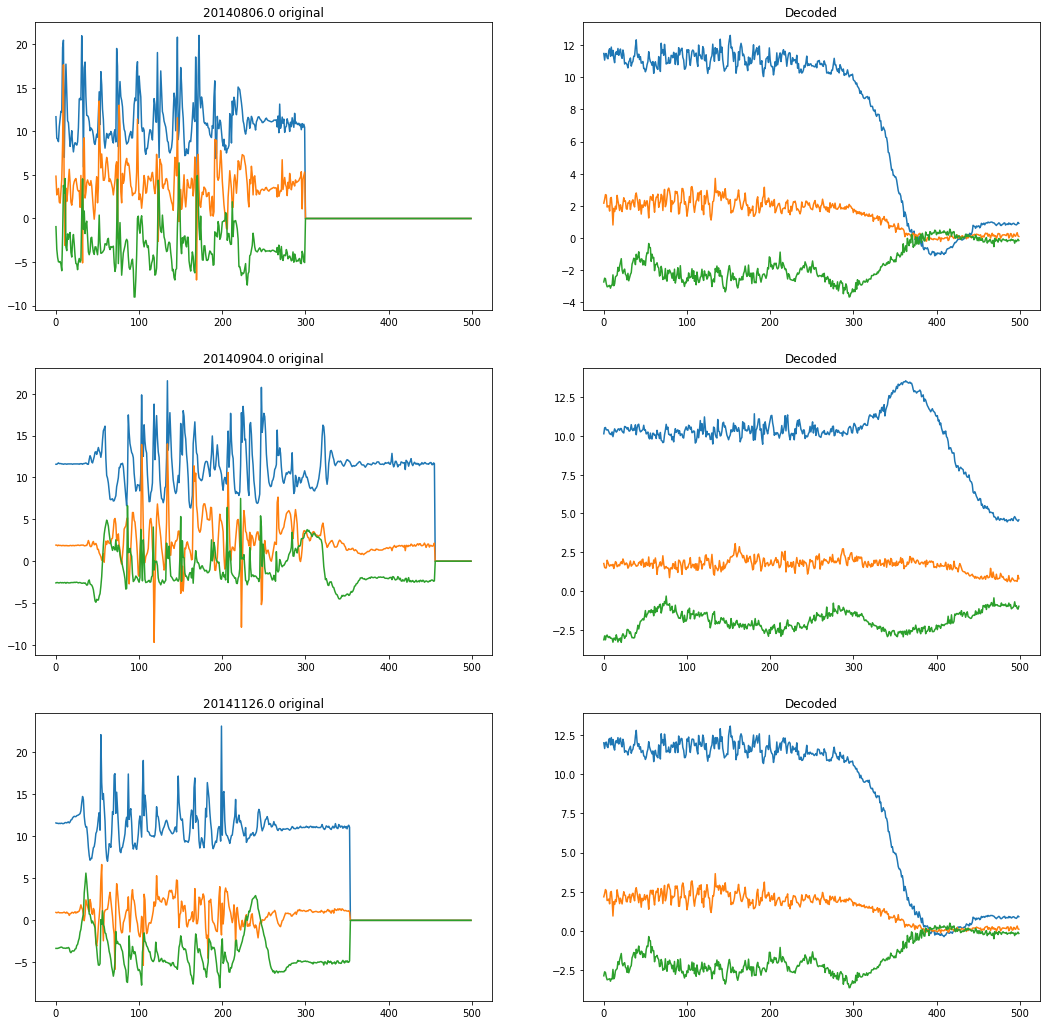

In [15]:
fig = plt.figure(figsize=(18, 18)) # 18x9 inches to fit 3 rows * 2 columns subplots
sub = 0 # sub graph index
for i in range(0, 3):
    sub +=1
    a=fig.add_subplot(3, 2, sub) # we have a 3 rows * 2 columns subplots
    original = b_x[i].data.numpy().reshape(500, 3)
    plt.plot(original)
    title = str(y[i]) + ' original'
    plt.title(title)

    sub +=1
    a=fig.add_subplot(3, 2, sub)
    recovered = decoded[i].data.numpy().reshape(500, 3)
    plt.plot(recovered)
    plt.title("Decoded")
    
plt.show()